In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader

from models.macaw import MACAW
from utils.datasets import TorchDataset as TD
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mode = 'test'
test_block = 'flat'

checkpoint = torch.load('checkpoints/PD-SFCN/best_model.pt')
weights = checkpoint['model_state_dict']['classifier.fc.weight'].data.cpu().numpy()
bias = checkpoint['model_state_dict']['classifier.fc.bias'].data.cpu().numpy()

In [3]:
model = MACAW(nlatents=64).to('cuda')
checkpoint = torch.load('checkpoints/act-macaw-flat/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

data_loader = DataLoader(TD(f'/data/Data/PD/activations_{test_block}_{mode}'), batch_size=128, shuffle=False)

In [4]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1 - y_true) * np.log(1 - y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0 + term_1, axis=0)


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def accuracy(y_true, y_pred, threshold=0.5):
    y_pred = y_pred > threshold
    return np.mean(y_pred == y_true)


In [5]:
import numpy as np

g_dict = {'Study': np.arange(8), 'Sex': [0, 1]}
cf_dict = {}
for i, g in enumerate(g_dict.keys()):
    grp_mean = np.zeros((167, 68))
    for v in g_dict[g]:
        obs = []
        cfs = []
        model.eval()
        for b in data_loader:
            x_obs, x_cf = model.counterfactuals(b.to('cuda'), cf_vals={i: v})
            obs.append(x_obs)
            cfs.append(x_cf)

        obs = np.vstack(obs)
        cf = np.vstack(cfs)
        grp_mean += cf

        cf_dict[f'{g}_{v}'] = cf

    cf_dict[f'{g}_mean'] = grp_mean / len(g_dict[g])

In [6]:
from sklearn.metrics import roc_curve, auc

obs_pred = sigmoid(obs[:, 4:] @ weights.T + bias).squeeze()
fpr, tpr, thresholds = roc_curve(obs[:, 3], obs_pred)
obs_roc_auc = auc(fpr, tpr)
obs_bce = BinaryCrossEntropy(obs[:, 3], obs_pred)
print(f'Obs- AUROC: {obs_roc_auc}, BCE:{obs_bce}')

df = pd.DataFrame(
    {'pd_true': obs[:, 3], 'obs_pred': obs_pred, 'sex': obs[:, 1], 'study': obs[:, 0], 'scanner': obs[:, 2]})
df

Obs- AUROC: 0.8368723098995695, BCE:0.5517953038215637


,pd_true,obs_pred,sex,study,scanner
0,0.0,0.534004,1.0,0.0,0.0
1,0.0,0.280552,0.0,1.0,1.0
2,1.0,0.692456,0.0,3.0,2.0
3,1.0,0.440494,0.0,1.0,1.0
4,1.0,0.563813,1.0,2.0,1.0
...,...,...,...,...,...
162,0.0,0.433368,0.0,0.0,0.0
163,0.0,0.326661,0.0,5.0,4.0
164,1.0,0.632287,1.0,0.0,0.0
165,0.0,0.243670,0.0,1.0,1.0


In [7]:
for k, v in g_dict.items():
    mean_pred = sigmoid(cf_dict[f'{k}_mean'][:, 4:] @ weights.T + bias).squeeze()
    fpr, tpr, thresholds = roc_curve(obs[:, 3], mean_pred)
    obs_roc_auc = auc(fpr, tpr)
    obs_bce = BinaryCrossEntropy(obs[:, 3], mean_pred)
    print(f'{k}- AUROC: {obs_roc_auc}, BCE:{obs_bce}')
    df[f'{k}_pred'] = mean_pred

Study- AUROC: 0.8248206599713056, BCE:0.5651169606249238
Sex- AUROC: 0.8370157819225251, BCE:0.5515832686737185


In [8]:
def compute_scanner_roc(df, y_true_col='pd_true', y_prob_col='pd_pred',
                        subgroup_col='scanner'):
    unique_scanners = df[subgroup_col].unique()

    scanner_roc_metrics = {}
    accuracy = {}
    for scanner in unique_scanners:
        scanner_df = df[df[subgroup_col] == scanner]
        y_true = scanner_df[y_true_col]
        y_prob = scanner_df[y_prob_col]

        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)

            # Store metrics
            scanner_roc_metrics[scanner] = {
                'fpr': fpr,
                'tpr': tpr,
                'thresholds': thresholds,
                'auc': roc_auc,
                'total_samples': len(scanner_df)
            }

        except ValueError as e:
            print(f"Error computing ROC for {subgroup_col} {scanner}: {e}")

    return scanner_roc_metrics


def plot_scanner_roc_curves(df, y_true_col='y_true', y_prob_col='y_pred',
                            subgroup_col='scanner', figsize=(6, 6)):
    # Compute ROC metrics for each scanner
    scanner_roc_metrics = compute_scanner_roc(
        df, y_true_col, y_prob_col, subgroup_col
    )

    fig, axs = plt.subplots(1, 1, figsize=figsize)
    colors = sns.color_palette('husl', len(scanner_roc_metrics))

    # Plot ROC for each scanner
    for (scanner, metrics), color in zip(scanner_roc_metrics.items(), colors):
        axs.plot(metrics['fpr'], metrics['tpr'],
                    label=f'{scanner} (AUC = {metrics["auc"]:.3f}, n={metrics["total_samples"]})',
                    color=color)

    # Plot random classifier line
    axs.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    # Customize plot
    axs.set_xlim([0.0, 1.0])
    axs.set_ylim([0.0, 1.05])
    axs.set_xlabel('False Positive Rate', fontsize=12)
    axs.set_ylabel('True Positive Rate', fontsize=12)
    axs.set_title(f'ROC Curves by {subgroup_col}', fontsize=14)
    axs.legend(loc="lower right", fontsize=10)
    axs.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'/data/Papers/MICCAI-biases/macaw-analysis/{y_prob_col}_{subgroup_col}.pdf', dpi=300)
    plt.show()

    return scanner_roc_metrics


# Comprehensive analysis function
def comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='pd_pred',
                                      subgroup_col='scanner', thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0, 1, 100)

    # Compute ROC curves
    roc_metrics= plot_scanner_roc_curves(df, y_true_col, y_prob_col, subgroup_col)

    return roc_metrics

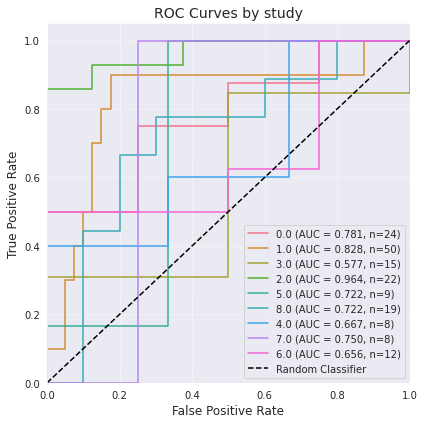

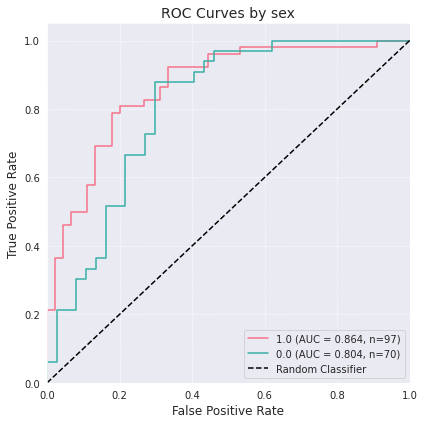

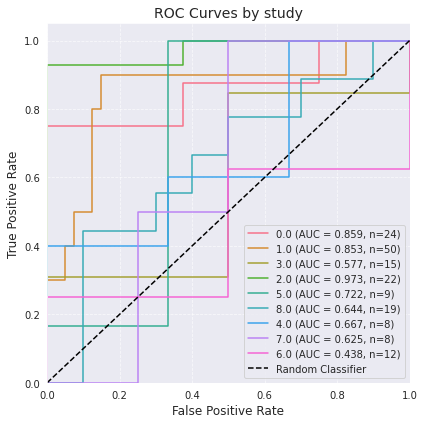

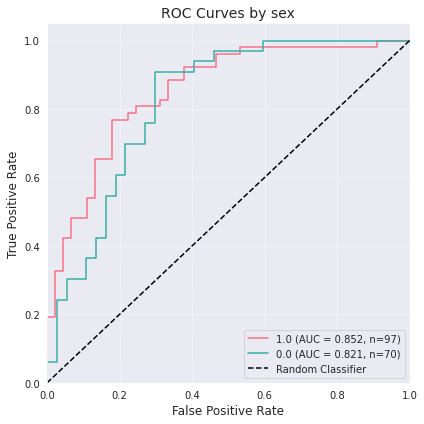

In [10]:
study_obs_metrics = comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='obs_pred',
                                                        subgroup_col='study')

sex_obs_metrics = comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='obs_pred',
                                                        subgroup_col='sex')

study_cf_study_metrics = comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='Study_pred',
                                                        subgroup_col='study')

sex_cf_sex_metrics = comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='Sex_pred',
                                                        subgroup_col='sex')

In [11]:
cf_study_study_auc = {}

for a in study_obs_metrics.keys():
    cf_study_study_auc[a] = (study_cf_study_metrics[a]['auc'] - study_obs_metrics[a]['auc'])
    
cf_sex_sex_auc = {}

for a in sex_obs_metrics.keys():
    cf_sex_sex_auc[a] = (sex_cf_sex_metrics[a]['auc'] - sex_obs_metrics[a]['auc'])   

In [12]:
cf_study_study_auc

{0.0: 0.078125,
 1.0: 0.02499999999999991,
 3.0: 0.0,
 2.0: 0.008928571428571397,
 5.0: 0.0,
 8.0: -0.07777777777777772,
 4.0: 0.0,
 7.0: -0.125,
 6.0: -0.21875}

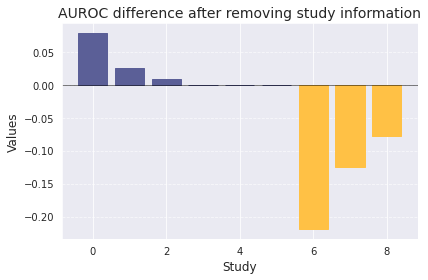

In [36]:
plt.figure(figsize=(6, 4))

# Create bar plot with custom colors
bars = plt.bar(cf_study_study_auc.keys(), cf_study_study_auc.values())

# Color bars based on positive/negative values
for i, value in enumerate(cf_study_study_auc.values()):
    if value >= 0:
        bars[i].set_color('#5B5F97')
    else:
        bars[i].set_color('#FFC145')

# Customize the plot
plt.title('AUROC difference after removing study information', fontsize=14)
plt.xlabel('Study', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f'/data/Papers/MICCAI-biases/macaw-analysis/cf_study_diff.pdf', dpi=300)
plt.show()

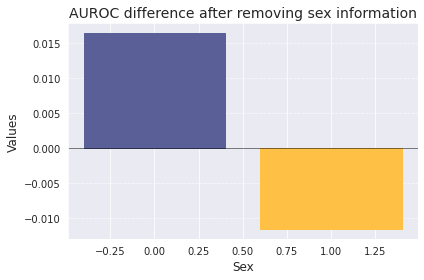

In [37]:
plt.figure(figsize=(6, 4))

# Create bar plot with custom colors
bars = plt.bar(cf_sex_sex_auc.keys(), cf_sex_sex_auc.values())


# Color bars based on positive/negative values
for i, value in enumerate(cf_sex_sex_auc.values()):
    if value >= 0:
        bars[i].set_color('#5B5F97')
    else:
        bars[i].set_color('#FFC145')

# Customize the plot
plt.title('AUROC difference after removing sex information', fontsize=14)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f'/data/Papers/MICCAI-biases/macaw-analysis/cf_sex_diff.pdf', dpi=300)
plt.show()

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns


def joint_plot(pca_0, pca_1, col, name, cat = None, savename = 'pca'):
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(4, 4, wspace=0, hspace=0)

    # Create the scatter plot and marginal axes
    ax_scatter = fig.add_subplot(gs[1:, :-1])
    ax_histx = fig.add_subplot(gs[0, :-1], sharex=ax_scatter)
    ax_histy = fig.add_subplot(gs[1:, -1], sharey=ax_scatter)
    
    mask = []
    if cat is None:
        cat = np.unique(col)
    
    for category in cat:
        mask.append(col == category)
        
    mask = np.bitwise_or.reduce(mask, axis=0)
       
    pca_0 = pca_0[mask]
    pca_1 = pca_1[mask]
    col = col[mask]
    
    sns.scatterplot(x=pca_0, y=pca_1, hue=col, palette='deep', alpha=0.6,
                    ax=ax_scatter, legend=False)
    
    palette = sns.color_palette('deep', 15)
    for category, color in zip(cat, palette[:len(cat)]):
        mask = col == category
        sns.kdeplot(x=pca_0[mask], ax=ax_histx, color=color, fill=True, alpha=0.5, label=category)
        sns.kdeplot(y=pca_1[mask], ax=ax_histy, color=color, fill=True, alpha=0.5, label=category)

    ax_histx.set_ylabel('')
    ax_histx.set_title(name)
    ax_histy.set_xlabel('')

    ax_scatter.set_xlabel(f'PCA 0')
    ax_scatter.set_ylabel(f'PCA 1')

    ax_scatter.set_xticks([])
    ax_scatter.set_yticks([])

    ax_histx.grid(False)
    ax_histy.grid(False)

    ax_histx.set_xticks([])
    ax_histx.set_yticks([])

    ax_histy.set_xticks([])
    ax_histy.set_yticks([])

    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.savefig(f'/data/Papers/MICCAI-biases/macaw-analysis/{savename}.pdf', dpi=300)
    plt.show()

    return fig


def heatmap(data, title):
    # Seaborn 1D Heatmap
    plt.figure(figsize=(20, 1))
    sns.heatmap(data, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
pca_obs =  pca.fit_transform(obs[:,4:])
pca_cf_study =  pca.transform(cf_dict['Study_mean'][:,4:])
pca_cf_sex =  pca.transform(cf_dict['Sex_mean'][:,4:])

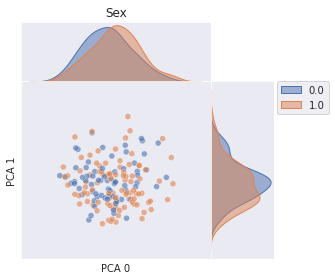

In [40]:
fig = joint_plot(pca_obs[:,0], pca_obs[:, 1], obs[:,1], 'Sex', savename='obs_sex_pca0')

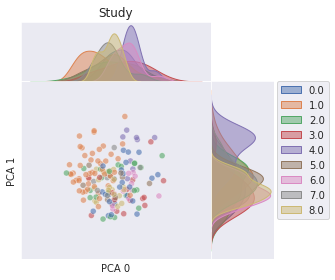

In [41]:
fig = joint_plot(pca_obs[:,0], pca_obs[:, 1], obs[:,0], 'Study',savename='obs_study_pca0')

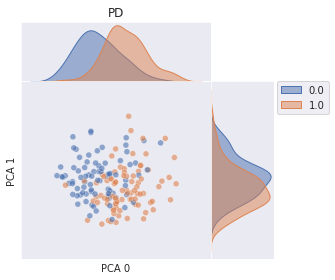

In [42]:
fig = joint_plot(pca_obs[:,0], pca_obs[:, 1], obs[:,3], 'PD',savename='obs_pd_pca0')

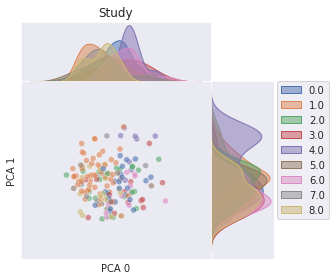

In [43]:
fig = joint_plot(pca_cf_study[:,0], pca_cf_study[:, 1], obs[:,0], 'Study',savename='cf_study_study_pca0')

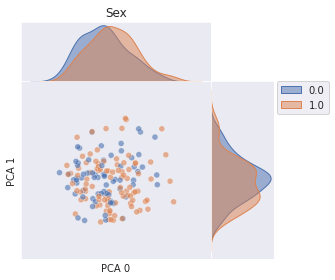

In [44]:
fig = joint_plot(pca_cf_study[:,0], pca_cf_study[:, 1], obs[:,1], 'Sex',savename='cf_study_sex_pca0')

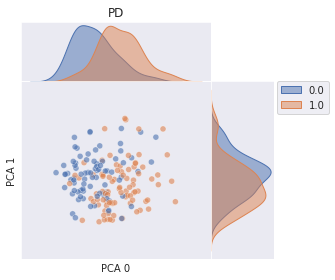

In [45]:
fig = joint_plot(pca_cf_study[:,0], pca_cf_study[:, 1], obs[:,3], 'PD',savename='cf_study_pd_pca0')

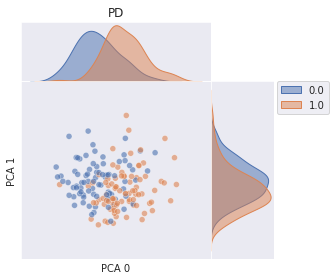

In [46]:
fig = joint_plot(pca_cf_sex[:,0], pca_cf_sex[:, 1], obs[:,3], 'PD',savename='cf_sex_pd_pca0')

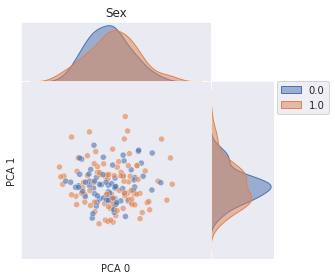

In [47]:
fig = joint_plot(pca_cf_sex[:,0], pca_cf_sex[:, 1], obs[:,1], 'Sex',savename='cf_sex_sex_pca0')

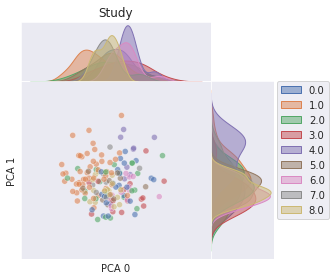

In [48]:
fig = joint_plot(pca_cf_sex[:,0], pca_cf_sex[:, 1], obs[:,0], 'Study',savename='cf_sex_study_pca0')

## Individual CF study - doesn't make sense yet

In [18]:
sus_dict = {'Study': obs[:, 0], 'Sex': obs[:, 1], 'Scanner': obs[:, 2], 'PD': obs[:, 3], 'obs_pred': obs_pred}

for k, v in cf_dict.items():
    sus_dict[k] = sigmoid(v[:, 4:] @ weights.T + bias).squeeze()

In [19]:
sus_df = pd.DataFrame.from_dict(sus_dict)
sus_df

,Study,Sex,Scanner,PD,obs_pred,Study_0,Study_1,Study_2,Study_3,Study_4,Study_5,Study_6,Study_7,Study_mean,Sex_0,Sex_1,Sex_mean
0,0.0,1.0,0.0,0.0,0.534004,0.534004,0.532428,0.531968,0.531936,0.532002,0.532259,0.532669,0.533215,0.532560,0.526426,0.534004,0.530217
1,1.0,0.0,1.0,0.0,0.280552,0.263680,0.280552,0.297216,0.313282,0.328699,0.343502,0.357655,0.371104,0.318404,0.280552,0.314262,0.297131
2,3.0,0.0,2.0,1.0,0.692456,0.702136,0.698214,0.695249,0.692456,0.689774,0.687257,0.684885,0.682639,0.691612,0.692456,0.695385,0.693923
3,1.0,0.0,1.0,1.0,0.440494,0.421067,0.440494,0.458554,0.475214,0.490531,0.504692,0.517738,0.529629,0.479623,0.440494,0.476104,0.458245
4,2.0,1.0,1.0,1.0,0.563813,0.544882,0.554692,0.563813,0.572116,0.579658,0.586518,0.592809,0.598458,0.574210,0.540424,0.563813,0.552147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.0,0.0,0.0,0.0,0.433368,0.433368,0.438647,0.444363,0.450131,0.455977,0.461636,0.467092,0.472318,0.452910,0.433368,0.451648,0.442488
163,5.0,0.0,4.0,0.0,0.326661,0.238871,0.257674,0.275862,0.293474,0.310427,0.326661,0.342134,0.356822,0.298776,0.326661,0.357035,0.341685
164,0.0,1.0,0.0,1.0,0.632287,0.632287,0.635238,0.638414,0.641343,0.643588,0.645514,0.647137,0.648523,0.641524,0.616338,0.632287,0.624346
165,1.0,0.0,1.0,0.0,0.243670,0.225132,0.243670,0.262088,0.280015,0.297354,0.314122,0.330247,0.345629,0.285610,0.243670,0.280704,0.261765


In [20]:
auroc_dict = {}
bce_dict = {}

for k in cf_dict.keys():
    fpr, tpr, thresholds = roc_curve(sus_dict['PD'], sus_dict[k])
    roc_auc = auc(fpr, tpr)
    auroc_dict[k] = roc_auc - obs_roc_auc
    bce_dict[k] = BinaryCrossEntropy(sus_dict['PD'], sus_dict[k]) - obs_bce

<BarContainer object of 12 artists>

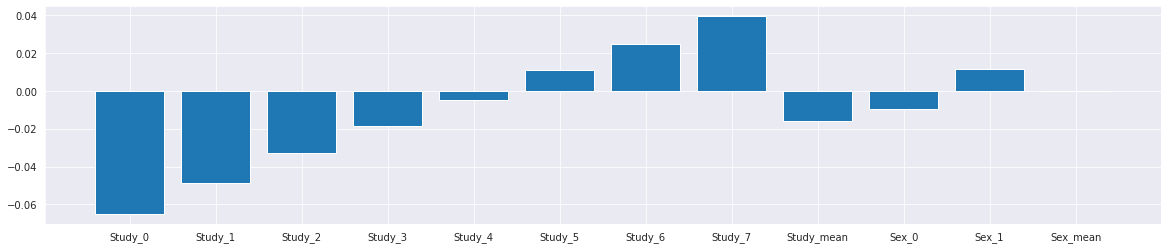

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(20, 4))
plt.bar(auroc_dict.keys(), auroc_dict.values())

<BarContainer object of 12 artists>

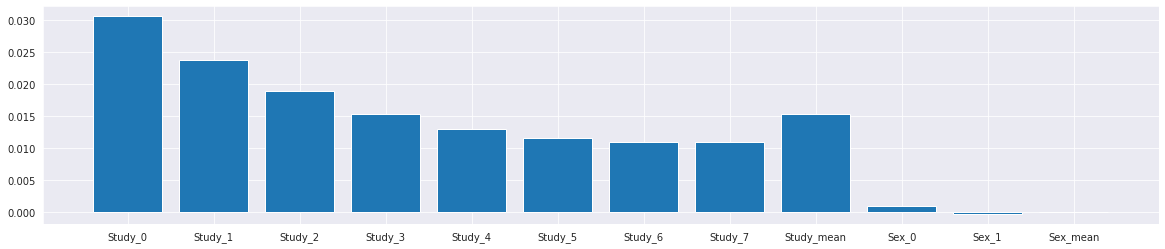

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(20, 4))
plt.bar(bce_dict.keys(), bce_dict.values())

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
pca_dict = {'obs': pca.fit_transform(obs[:, 4:])}

for k, v in cf_dict.items():
    pca_dict[k] = pca.transform(v[:, 4:])

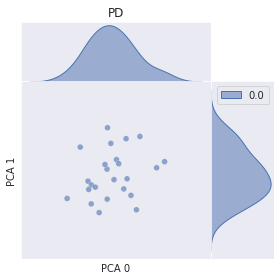

In [24]:
k = 'Study_6'
fig = joint_plot(pca_dict[k][:, 0], pca_dict[k][:, 1], obs[:, 0], 'PD', cat = [0.0])

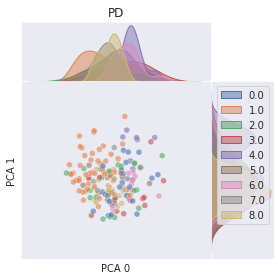

In [25]:
k = 'obs'
fig = joint_plot(pca_dict[k][:, 0], pca_dict[k][:, 1], obs[:, 0], 'PD')

In [26]:
fig = joint_plot(obs_latent_pca[:, 0], obs_latent_pca[:, 1], obs_sex, 'Study')

NameError: name 'obs_latent_pca' is not defined

In [ ]:
fig = joint_plot(cf_latent_pca[:, 0], cf_latent_pca[:, 1], obs_PD, 'PD')

In [ ]:
fig = joint_plot(cf_latent_pca[:, 0], cf_latent_pca[:, 1], obs_sex, 'PD')